# Sistemas Dinâmicos e Controlo - Projeto

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import StateSpace, lsim, step, lti
from pprint import pprint

In [2]:
m = 1.5 * 10 ** -1 # motorcycle mass
g = 9.81 # gravity
h = 8.0 * 10 ** -1 # height of center of mass
I = 1.5 * 10 ** -2 # moment of inertia

## Ex. 1

$$ I \ddot{\theta} = mgh \cdot sin(\theta) + \tau $$

At small angles $ sin(\theta) \approx \theta $.

$$ I \ddot{\theta} = mgh \cdot \theta + \tau $$

$$ \ddot{\theta} = \frac{mgh \cdot \theta}{I} + \frac{\tau}{I} $$

$$ x = \begin{bmatrix} 
 \theta \\
 \dot{\theta} \\
\end{bmatrix} \Leftrightarrow \dot{x} = \begin{bmatrix} 
 \dot{\theta} \\
 \ddot{\theta} \\
\end{bmatrix} \Leftrightarrow \dot{x} = \begin{bmatrix} 
 \dot{\theta} \\
 \frac{mgh}{I}\cdot \theta + \frac{\tau}{I} \\
\end{bmatrix} \Leftrightarrow \dot{x} = \begin{bmatrix} 
 \dot{\theta} \\
 \frac{mgh}{I}\cdot \theta \\
\end{bmatrix} + \begin{bmatrix}
0 \\
\frac{\tau}{I}
\end{bmatrix}  \Leftrightarrow \dot{x} = \begin{bmatrix} 
 0 & 1 \\
 \frac{mgh}{I}  & 0\\
\end{bmatrix} \begin{bmatrix}
 \theta \\
 \dot{\theta}
\end{bmatrix} + \begin{bmatrix}
0 \\
\frac{\tau}{I}
\end{bmatrix}  $$

Since $ u = \tau $:

$$
\dot{x} = \begin{bmatrix} 
 0 & 1 \\
 \frac{mgh}{I}  & 0\\
\end{bmatrix} \begin{bmatrix}
 \theta \\
 \dot{\theta}
\end{bmatrix} + \begin{bmatrix}
0 \\
\frac{1}{I}
\end{bmatrix} u $$

Since $\theta$ and $\dot{\theta}$ are also the output, $y$:

$$ y = C \cdot x \Leftrightarrow y = C \cdot \begin{bmatrix}
\theta \\ \dot \theta
\end{bmatrix} \Leftrightarrow y = \begin{bmatrix}
1 & 0 \\
0 & 1 \\
\end{bmatrix} \cdot \begin{bmatrix}
\theta \\ \dot \theta
\end{bmatrix} \Leftrightarrow C = \begin{bmatrix}
1 & 0 \\
0 & 1 \\
\end{bmatrix} $$
 


In [3]:
A = np.array([[0, 1],[m * g * h / I, 0]])
B = np.array([[0],[1 / I]])
C = np.array([[1, 0],[0, 1]])
D = np.array([[0],[0]])

print("Matriz A: ")
pprint(A)
print("Matrix B: ")
pprint(B)
print("Matrix C: ")
pprint(C)

Matriz A: 
array([[ 0.  ,  1.  ],
       [78.48,  0.  ]])
Matrix B: 
array([[ 0.        ],
       [66.66666667]])
Matrix C: 
array([[1, 0],
       [0, 1]])


## Ex.2

Controlability Matrix:

$$ Q = \begin{bmatrix} B & AB & A^{2}B & ... & A^{n-1}B \end{bmatrix} $$

Since $n=2$ and the controlability matrix is squared, if $ |Q| \neq 0 $, the system is controllable, if $ |Q| = 0 $, the system is not controllable.

$$ Q = \begin{bmatrix} B & AB  \end{bmatrix} $$

Other way to check, is to see if $rank(Q)=n$, then it's controllable.

In [4]:
Q = np.hstack([B, A @ B])
n=2

In [5]:
print("Controlability Matrix: ")
pprint(Q)
print("Determinant: ", np.linalg.det(Q))
print("Rank: ", np.linalg.matrix_rank(Q))

if np.linalg.det(Q) != 0:
    print("According to the determinant, the system is controllable")
else:
    print("According to the determinant, the system is not controllable")

if np.linalg.matrix_rank(Q) == n:
    print("According to the rank, the system is controllable.")
else:
    print("According to the rank, the system is not controllable.")

Controlability Matrix: 
array([[ 0.        , 66.66666667],
       [66.66666667,  0.        ]])
Determinant:  -4444.444444444446
Rank:  2
According to the determinant, the system is controllable
According to the rank, the system is controllable.


Observability Matrix:


$$ O = \begin{bmatrix} C \\ CA \\ CA^{2} \\ ... \\ CA^{n-1} \end{bmatrix} $$

If $rank(O)=n$, it's observable.

In [6]:
O = np.vstack([C, C @ A])  # Stack rows for observability

print("Observability Matrix:")
pprint(O)
print("Rank: ", np.linalg.matrix_rank(O))

if np.linalg.matrix_rank(O) == n: #n continua a ser 2 porque é o número de estados
    print("According to the rank, the system is observable.")
else:
    print("According to the rank, the system is not observable.")

Observability Matrix:
array([[ 1.  ,  0.  ],
       [ 0.  ,  1.  ],
       [ 0.  ,  1.  ],
       [78.48,  0.  ]])
Rank:  2
According to the rank, the system is observable.


Stability:

A system is stable if the real part of the eigenvalues is negative.

In [7]:
eigval, eigvect = np.linalg.eig(A)

print("Eigenvalues: ",eigval)

if eigval.real.any()<0: 
    print("The system is stable.")
else:
    print("The system is not stable.")

Eigenvalues:  [ 8.85889384 -8.85889384]
The system is not stable.


To stabilize this system, we can introduce a controller $K=[k_1 k_2]$ such that it stabilizes with poles at the system eigenvalues:

$$ det(sI-A+BK) = (s-\lambda_1)(s-\lambda_2) = s^2 - \lambda^2 $$

Where: 

$$ det(sI-A+BK) =  
det \begin{bmatrix} 
 s & 1 \\
 -\frac{mgh}{I}+\frac{k_1}{I}  & s+\frac{k_2}{I}\\
\end{bmatrix}  = s^2 + \frac{k_2}{I}s -1(\frac{k_1}{I}-\frac{mgh}{I})
$$

So:

$$ k_2=0 $$ 
and 
$$ k_1=I\lambda^2 + mgh $$

This way, the system can be stabilized.

In [8]:
K = np.hstack([I*eigval[0]+m*g*h,0])

print("Controller: ",K)

Controller:  [1.31008341 0.        ]


## Ex.3

In [9]:
# Sistema no formato lti (linear time-invariant)
sys = lti(A, B, C, D)

time = np.linspace(0, 5, 50)  # tempo de simulação

#### a) Step input, u = 10**-2, and null initial conditions, x0 = [0, 0]

In [10]:
# Resposta temporal - Condição inicial nula e entrada tipo degrau
u_step = np.ones_like(time) * 1e-2  # degrau de magnitude 10^-2 (eu não sei se aqui ele quer só a constante ou vários degraus)
x0_zero = [0, 0]  # condição inicial nula

# Simulação para entrada tipo degrau
_, y_step, _ = lsim(sys, U=u_step, T=time, X0=x0_zero)

#### b) Null input, u = 0, and non-null initial conditions, x0 = [x01, x02]

In [11]:
# Resposta temporal - Condição inicial não nula e entrada nula
x0_nonzero = [100,100]  # condição inicial não nula
u_zero = np.zeros_like(time)  # entrada nula

# Simulação para condição inicial não nula
_, y_initial, _ = lsim(sys, U=u_zero, T=time, X0=x0_nonzero)

Gráficos

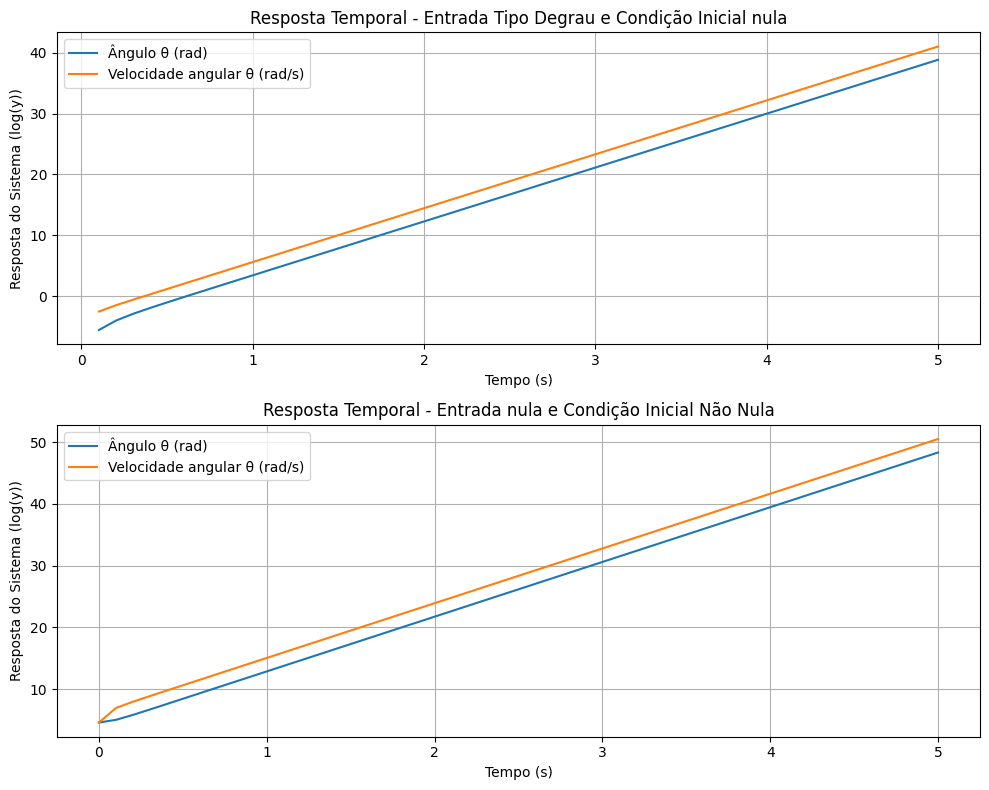

In [12]:
# Gráficos para análise
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico para entrada degrau (aqui tirei o primeiro ponto do gráfico porque dá erro pôr 0 no log)
axs[0].plot(time[1:], np.log(y_step[1:, 0]), label="Ângulo θ (rad)")
axs[0].plot(time[1:], np.log(y_step[1:, 1]), label="Velocidade angular θ̇ (rad/s)")
axs[0].set_title("Resposta Temporal - Entrada Tipo Degrau e Condição Inicial nula")
axs[0].set_xlabel("Tempo (s)")
axs[0].set_ylabel("Resposta do Sistema (log(y))")
axs[0].legend()
axs[0].grid()

# Gráfico para condição inicial não nula
axs[1].plot(time, np.log(y_initial[:, 0]), label="Ângulo θ (rad)")
axs[1].plot(time, np.log(y_initial[:, 1]), label="Velocidade angular θ̇ (rad/s)")
axs[1].set_title("Resposta Temporal - Entrada nula e Condição Inicial Não Nula")
axs[1].set_xlabel("Tempo (s)")
axs[1].set_ylabel("Resposta do Sistema (log(y))")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

## Design of Controllers in State Space

### Ex.4

$$ A - Bk = \begin{bmatrix}
0 & 1 \\
mgh/I & 0  \\
\end{bmatrix} - \begin{bmatrix}
0 \\
1/I
\end{bmatrix} \begin{bmatrix}
k_{1} & k_{2} \\
\end{bmatrix} = \\ = \begin{bmatrix}
0 & 1 \\
mgh/I & 0  \\
\end{bmatrix} - \begin{bmatrix}
0 & 0 \\
\frac{k_{1}}{I} & \frac{k_{2}}{I} \\
\end{bmatrix} = \begin{bmatrix}
0 & 1 \\
\frac{mgh}{I} - \frac{k_{1}}{I} & -\frac{k_{2}}{I} \\
\end{bmatrix} = \begin{bmatrix}
0 & 1 \\
\frac{mgh-k_{1}}{I} & -\frac{k_{2}}{I} \\
\end{bmatrix} $$

$$ sI - (A-Bk) = s\begin{bmatrix}
1 & 0 \\
0 & 1 \\
\end{bmatrix} - \begin{bmatrix}
0 & 1 \\
\frac{mgh-k_{1}}{I} & -\frac{k_{2}}{I} \\
\end{bmatrix} = \\ \begin{bmatrix}
s & 0 \\
0 & s \\
\end{bmatrix} - \begin{bmatrix}
0 & 1 \\
\frac{mgh-k_{1}}{I} & -\frac{k_{2}}{I} \\
\end{bmatrix} = \begin{bmatrix}
s & -1 \\
- \frac{mgh-k_{1}}{I} & s+ \frac{k_{2}}{I} \\
\end{bmatrix} $$

$$ det(sI - (A-Bk))= 0
\Leftrightarrow det  \begin{bmatrix}
s & -1 \\
- \frac{mgh-k_{1}}{I} & s+ \frac{k_{2}}{I} \\
\end{bmatrix} \Leftrightarrow \\ \begin{bmatrix}
s & -1 \\
- \frac{mgh-k_{1}}{I} & s+ \frac{k_{2}}{I} \\
\end{bmatrix}= 0 \Leftrightarrow s\left(s+\frac{k_{2}}{I}\right)- (-1)\left(-\frac{mgh-k_{1}}{I}\right) = 0 \Leftrightarrow \\s^{2} + \frac{k_{2}}{I}s + \frac{k_{1}-mgh}{I} = 0 \Leftrightarrow 
s^{2} +2\left(\frac{k_{2}}{2I}\right)s - \left(\sqrt{\frac{k_{1}-mgh}{I}}\right)^{2} = 0
$$

$$ s^{2} + 2\xi \omega_{n} + \omega_{n}^{2} = 0
\Leftrightarrow s_{1,2} = -\xi \omega_{n} \pm  j\omega_{n}\sqrt{1-\xi^{2}} $$

Settling time:
$$ t_{s} \cong \frac{4}{\xi \omega_{n}} \Leftrightarrow \xi = \frac{4}{\omega_{n} t_{s}} $$

$$
\frac{k_{2}}{2I} = \xi \omega_{n} \Leftrightarrow k_{2} = 2I\xi \omega_{n}  \\
$$

$$ \sqrt{\frac{k_{1}-mgh}{I}} = \omega_{n} \Leftrightarrow \frac{k_{1}-mgh}{I} = \omega_{n}^{2} \Leftrightarrow k_{1}-mgh=I\omega_{n}^{2} \Leftrightarrow k_{1} = mgh + I\omega_{n}^{2} $$

Overshoot: $$M=e^{-\frac{\xi \pi}{\sqrt{1-\xi^2}}}$$

(versão do Nuno)

**Função transferência**
- Os zeros de $p(s)$ são:
$$\lambda_{1}=-\xi\omega_{n} + j\omega_{n}\sqrt{1-\xi^{2}} \quad;\quad \lambda_{2}=-\xi\omega_{n} - j\omega_{n}\sqrt{1-\xi^{2}}$$
e podemos escrever a função transferência do sistema:
$$\frac{Y}{U}= \frac{1}{(s-\lambda_{1})(s-\lambda_{2})}=\frac{A}{s-\lambda_{1}}+ \frac{B}{s-\lambda_{2}}$$
- Podemos determinar os coeficientes: $A=\frac{1}{\lambda_{2}-\lambda_{1}}~,~B=\frac{1}{\lambda_{1}-\lambda_{2}}=-A$. Logo:
$$\frac{Y}{U}=\frac{1}{\lambda_{2}-\lambda_{1}} \left(\frac{1}{s-\lambda_{1}} - \frac{1}{s-\lambda_{2}}\right)$$
em que temos $\lambda_{2}-\lambda_{1}=-2j\omega_{n}\sqrt{1-\xi^{2}}$.

**Evolução temporal**
- A partir disto podemos obter:
$$\begin{align*}
y(t)&= y_{0} \cdot \frac{1}{2j\omega_{n}\sqrt{1-\xi^{2}}} (e^{\lambda_{1}t} - e^{\lambda_{2}t})\\
&= \frac{y_{0}}{2j\omega_{n}\sqrt{1-\xi^{2}}} \left(e^{t(-\xi\omega_{n}+j\omega_{n}\sqrt{1-\xi^{2}})} - e^{t(-\xi\omega_{n}-j\omega_{n}\sqrt{1-\xi^{2}})} \right)\\
&= \frac{y_{0}}{2j\omega_{n}\sqrt{1-\xi^{2}}} e^{-\xi\omega_{n}t}\left(e^{j \omega_{n}\sqrt{1-\xi^{2}}t} - e^{-j \omega_{n}\sqrt{1-\xi^{2}}t} \right)\\
&= \frac{y_{0}}{\omega_{n}\sqrt{1-\xi^{2}}} e^{-\xi\omega_{n}t}\sin (\omega_{n}\sqrt{1-\xi^{2}}t)
\end{align*}$$

**Condições desejadas**
- Queremos 2 coisas: overshoot máximo de $0.05$ e queremos que o sistema esta estabilizado em $t=2$

*Tempo de settle*
- Podemos garantir que em $t=2$ o sistema está settled forçando a da exponencial abaixo de uma certa tolerância $T$ (isto porque o termo exponencial é que decide a amplitude)
$$\begin{align*}
|e^{-\xi\omega_{n}\cdot2}|&\le T\\
2\xi\omega_{n}&\ge \ln \frac{1}{T}\\
\omega_{n}&\ge \frac{1}{2\xi}\ln \frac{1}{T} 
\end{align*}$$

*Overshoot*
- Começamos com o ângulo nulo. Depois do impulso de torque teremos velocidade angular não nula. Isto vai fazer o ângulo aumentar. O nosso sistema tem o objetivo de reduzir o ângulo de volta para zero, mas sem passar o nível de overshoot desejado, abaixo de zero.
- A função consiste numa sinusoide com amplitude controlada por uma exponencial. Assim, o primeiro mínimo irá acontecer quando:
$$\begin{align*}
\sin (\omega_{n}\sqrt{1-\xi^{2}}t)&= -1\\
\omega_{n}\sqrt{1-\xi^{2}}t&= \frac{3\pi}{2}\\
t&= \frac{3\pi}{2\omega_{n}\sqrt{1-\xi^{2}}}
\end{align*}$$

- Aqui a melhor forma que temos é limitar a exponencial:
$$\begin{align*}
e^{-\xi\omega_{n}t}&\le  0.05+T\\
\exp \left(-\xi \omega_{n} \frac{3\pi/2}{\omega_{n}\sqrt{1-\xi^{2}}} \right)&\le 0.05+T\\
\frac{\xi\cdot 3\pi/2}{\sqrt{1-\xi^{2}}}&\ge \ln \frac{1}{0.05+T}\\
\xi^{2}\left(\frac{3\pi}{2}\right)^{2} &\ge \left(\ln \frac{1}{0.05+T}\right)^{2}(1-\xi^{2}) \\
\xi^{2}\left(\left(\frac{3\pi}{2}\right)^{2}+\left(\ln \frac{1}{0.05+T}\right)^{2}\right)&\ge \left(\ln \frac{1}{0.05+T}\right)^{2}\\
\xi&\ge \sqrt{\frac{\left(\ln \frac{1}{0.05+T}\right)^{2}}{\left(\frac{3\pi}{2}\right)^{2}+\left(\ln \frac{1}{0.05+T}\right)^{2}}}
\end{align*}$$
Assim definimos uma tolerância $T$ e temos:
$$\xi=\sqrt{\frac{\left(\ln \frac{1}{0.05+T}\right)^{2}}{\left(\frac{3\pi}{2}\right)^{2}+\left(\ln \frac{1}{0.05+T}\right)^{2}}} \quad;\quad \omega_{n}=\frac{1}{2\xi}\ln \frac{1}{T} $$

*Notas*
- Como podemos ver no gráfico abaixo, a função analítica que usamos nestas deduções coincide completamente com o comportamento do sistema de feedback.

- Ao variar a tolerância vemos que o overshoot e o tempo de settling tornam-se cada vez menores. Uma tolerância de $T=10^{-4}$ já nos dá um vetor $K$ em que o sistema cumpre os requisitos.

- De acordo com as equações acima, podemos multiplicar o valor de $\omega_n$ por qualquer constante >1 e o sistema funciona bem, estabilizando mais rápido. Já para $\xi$, a inequação não se aplicar, uma vez que aumentar $\xi$ diminui $\omega_n$ e deixamos de cumprir os requisitos

Temos $\dot x=(A-BK)x$ logo podemos discretizar o sistema:
$$\begin{align*}
dx/dt &= (A-BK)x\\
\frac{x_{i+1}-x_i}{\Delta t} &= (A-BK)x_i\\
x_{i+1}&= x_i + \Delta t (A-BK)x_i 
\end{align*}$$

e simplesmente aplicamos esta equação sucessivamente para determinar a sua evolução. Se $\Delta t$ for pequeno que chegue isto deverá dar uma evolução correta.

Para t<0: &nbsp; $$x(0^-) = \begin{bmatrix} \theta(0^-) \\ \dot{\theta}(0^-) \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$$


O impulso de torque tem efeito apenas em $\dot{\theta}$: &nbsp; $$ \Delta \dot{\theta} = \frac{\tau_{\text{impulse}}}{I}$$

Em t=0 (imediatamente após o impulso de torque): &nbsp; $$x(0^+) = \begin{bmatrix} \theta(0^+) \\ \dot{\theta}(0^+) \end{bmatrix} = \begin{bmatrix} 0 \\ \Delta \dot{\theta} \end{bmatrix} = \begin{bmatrix} 0 \\ \frac{\tau_{\text{impulse}}}{I} \end{bmatrix}$$

k =  [[2.28351745 0.13815511]]


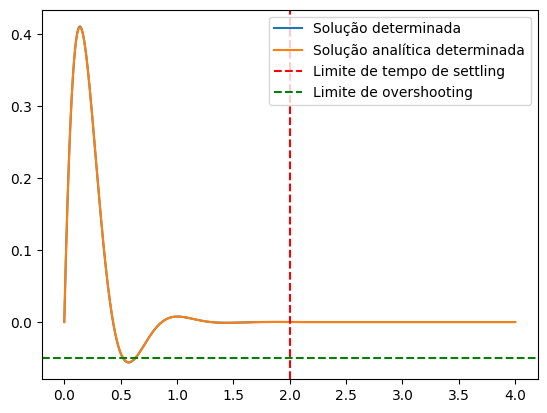

In [13]:
# ts = 2
# w = 5*10^-2
# xi = 4/(ts*w)
# overshoot = np.exp(-(xi*np.pi)/(np.sqrt(1-xi**2)))

# tau_impulse = 1.5 * 10 ** -2
# delta_theta_dot = tau_impulse / I
# x0 = [0, delta_theta_dot]

# k2 = 2*I*xi*w
# k1 = m*g*h-I*w*w
# k = np.array([k1,k2])

T = 1e-4
xi = np.sqrt((np.log(1/(T+0.05))**2)/((3*np.pi/2)**2 + np.log(1/(T+0.05))**2))
w = 1/(2*xi)*np.log(1/T)

k2 = 2*I*xi*w
k1 = m*g*h+I*w*w
k = np.array([k1,k2]).reshape((1,2))

# print("ts = ",ts)
# print("overshoot = ",overshoot)
print("k = ",k)


# representação gráfica
x0 = np.array([0,0.1/I])
times = np.linspace(0, 4, 10000, endpoint=True)
dt = abs(times[1]-times[0])
xt = np.zeros((len(times), 2))
xt[0] = x0
for i in range(len(times)-1):
    xt[i+1] = xt[i] + dt*(A - B @ k) @ xt[i]

analitico = lambda xi, w, t, y0: y0/(w*np.sqrt(1-xi*xi)) * np.exp(-xi*w*t) * np.sin(w*np.sqrt(1-xi*xi)*t)

plt.plot(times, xt[:,0], label='Solução determinada')
plt.plot(times, analitico(xi, w, times, 0.1/I), label='Solução analítica determinada')
plt.axvline(2, linestyle='--', color='red', label='Limite de tempo de settling')
plt.axhline(-5e-2, linestyle='--', color='green', label='Limite de overshooting')
plt.legend()
plt.show()

### Ex.5

Como $\tau=0$ temos apenas a componente $\tau_c$:

$$ I \ddot{\theta} = mgh \cdot sin(\theta) + \tau_{c} $$
$$\Leftrightarrow I \ddot{\theta} = mgh \cdot sin(\theta) + \frac{mv^{2}h}{r} \cdot cos(\theta) $$

Fazendo a aproximação para pequenos ângulos:

$$ I \ddot{\theta} = mgh\theta + \frac{mv^{2}h}{r} \cdot 1$$
$$\Leftrightarrow \ddot{\theta} = \frac{mgh\theta}{I} + \frac{mv^{2}h}{rI} $$

O ângulo de equilíbrio $\theta_0$ acontece quando $\ddot{\theta}=0$:

$$\Leftrightarrow 0 = \frac{mgh\theta_0}{I} + \frac{mv^{2}h}{rI} $$

$$\Leftrightarrow \theta_0 = - \frac{Imv^{2}h}{mghrI} $$

$$\Leftrightarrow \theta_0 = - \frac{v^{2}}{gr} \approx 0.115$$

O controlador K anterior estabilizava a $\theta=0$ logo não vai funcionar para este novo angulo de equilíbrio.

---

Para simplificar, definimos:

$$ \frac{mgh}{I} = A \quad e \quad \frac{mv^{2}h}{rI} = B $$
$$ \Rightarrow \ddot{\theta} = A\theta + B $$

Ficamos assim com a equação para $\theta(t)$:

$$ \theta(t) = c_{1} e^{\sqrt{A}t} + c_{2} e^{-\sqrt{A}t} -\frac{B}{A} $$

In [14]:
r = 2
v = 1.5
A = m * g * h / I
B = m * v**2 * h / (r*I)

## Design of a State Estimator

### Ex.6

### Ex.7

## Controller and State Estimator

### Ex.8